# CS 429: Information Retrieval

<br>

## Lecture 4: Dictionaries

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


<br><br><br>
<br><br><br>

---




Last time:

- skip lists, phrase search, biword index, positional index

Today:

- Efficient retrieval of postings lists
- Wildcard queries
- Spelling correction

Recall our friend the inverted index:

\begin{eqnarray*}
cat & \rightarrow &1,9,62   \\
dog & \rightarrow &1,2,9,31 \\
zebra & \rightarrow &2,62,150   \\
\end{eqnarray*}

Given a query term "dog", how can we efficiently retrieve the matching postings list? 

**dictionary:** data structure to lookup posting list of a term.

What data structure should we use?

- Hash table
- Binary tree
- B-tree

# Hash Table


In [1]:
index = {'cat': [1, 9, 62],
         'dog': [1, 2, 9, 31],
         'zebra': [2, 62, 150]}

In [2]:
query = 'dog'
index['dog']  # hash lookup, O(1)

[1, 2, 9, 31]

How does this work?

In [3]:
print(hash('dog'))
print(hash('cat'))
# See the Python's implementation of hash here: 
# http://stackoverflow.com/questions/2070276/where-can-i-find-source-or-algorithm-of-pythons-hash-function

-1478837241286492477
-4683256221252089767


In [4]:
# What happens when two objects return the same hash?
print(hash(-799031295820617361))

-799031295820617361


In practice, our memory is limited, so we may each key to a row in a smaller table:

![hashing](files/hashing.png)

Source: <http://www.laurentluce.com/posts/python-dictionary-implementation/>

# Hash Table for Inverted Index

Pros:

- $O(1)$ lookup time
- Simple

Cons:

- Cannot efficiently find minor variants (e.g., zebr*)

# Binary Trees

![binary](files/binary.png)

Source: [MRS Ch3](http://nlp.stanford.edu/IR-book/pdf/03dict.pdf)

# Binary Trees

Search time: $O(\log n)$

- Assumes a **balanced** tree

![unbalanced](files/unbalanced.png)

# B-Trees

Like a binary tree, but nodes can have between *a* and  *b* children, instead of just 2.

![btree](files/btree.png)

B-Tree [2,4]

# Wildcard queries with B-Trees

Search for "ana*"

![wildcard](files/wildcard.png)

# Spelling correction

- $k$-gram overlap
- Levenshtein
- Middle-ground

# Levenshtein distance

How to convert string1 into string2 with the minimum number of operations?

fast $\rightarrow$ cats ?

Operations:

- *insert*: fas $\xrightarrow{insert(t)}$ fas**t**
- *delete*: fast $\xrightarrow{delete(t)}$ fas
- *substitute*: fast $\xrightarrow{substitute(t,x)}$ fas**x**

cats $\xrightarrow{substitute(c, f)}$ <u>**f**</u>ats $\xrightarrow{insert(s)}$ fa<u>**s**</u>ts $\xrightarrow{delete(s)}$ fast (3 operations)

or

cats $\xrightarrow{substitute(c, f)}$ <u>**f**</u>ats $\xrightarrow{substitute(t,s)}$ fa<u>**s**</u>s $\xrightarrow{substitute(s,t)}$ fas<u>**t**</u> (3 operations)

but definitely not:

cats $\xrightarrow{insert(f)}$ <u>**f**</u>cats $\xrightarrow{delete(c)}$ fats $\xrightarrow{delete(t)}$ fas $\xrightarrow{delete(s)}$ fa $\xrightarrow{insert(s)}$ fa<u>**s**</u> $\xrightarrow{insert(t)}$ fas<u>**t**</u> (6 operations)

**Search problem**: Find the minimum number of operations to convert string **s** into string **t**

In [5]:
# Slow, recursive Levenshtein implementation
# (inspired by <http://en.wikipedia.org/wiki/Levenshtein_distance>)
def leven(s, t):

    # base case: empty strings
    if len(s) == 0:
        return len(t)  # cost of inserting all of t
    if len(t) == 0:
        return len(s)  # cost of inserting all of s

    # test if last characters match
    if s[-1] == t[-1]:
        cost = 0    # match; no cost
    else:
        cost = 1   # no match; cost of substituting one letter.

    # return minimum of 
    # - (1) delete char from s, 
    # - (2) delete char from t, and 
    # - (3) delete char from both
    return min(
        leven(s[:-1], t) + 1, # e.g., leven(fas, cats) + 1 (for deleting 't' from 'fast')
        leven(s, t[:-1]) + 1, # e.g., leven(fast, cat) + 1 (for deleting 's' from 'cats')
        leven(s[:-1], t[:-1]) +
          cost # e.g., leven(fas, cat) + cost (for 's'-> t)
    )  

In [6]:
# Python array slicing: 
# http://structure.usc.edu/numarray/node26.html
'fast'[:-1]

'fas'

In [7]:
print(leven('fast', 'cats'))

3


**From recursion to dynamic programming**

Why is this recursive implementation slow?

![leven](files/leven2.png)


**Dynamic programming**
- Avoids the duplicate computation of the recursive solution
- Fill in a table

![leven](files/leven.png)

Fill in table from left to right, top to bottom, taking the minimum of the  preceding cells.

- move right: insert a character into "cats"
- move down: delete a character from "cats"
- move diagonally (down and right): substitute a character in "cats" with one from "fast"
Source: [MRS CH3](http://nlp.stanford.edu/IR-book/pdf/03dict.pdf)

**Running time?**
<br><br><br>
<br><br><br>
$O(n*m)$, where `len(s)=n` and `len(t)=m`.

# Spelling correction with string edit distance

**Idea:** Find a term in the dictionary that has minimum edit distance to query term


*Tie-breaker*: term that is most frequent

In [8]:
# What's a defaultdict?
from collections import defaultdict
d = {}
# d['zebra'] # KeyError
# Adding default values is a bit of a pain...
if 'zebra' in d:
    d['zebra'] += 1
else:
    d['zebra'] = 0


# defaultdict does it for you:
d2 = defaultdict(lambda: 0)
d2['zebra'] = 10
d2['cat'] = 20
d2['dog']  # NB: Looking up a key inserts it in the default dict.
print('mouse=', d2['mouse'])
print(d2)

# value is the length of the dictionary
d3 = defaultdict(lambda: len(d3))
d3['zebra']
d3['cat']
d3['dog']  
print(d3)

mouse= 0
defaultdict(<function <lambda> at 0x10fcac8c8>, {'cat': 20, 'dog': 0, 'mouse': 0, 'zebra': 10})
defaultdict(<function <lambda> at 0x10fcac730>, {'cat': 1, 'dog': 2, 'zebra': 0})


In [9]:
# Fetch a list of word counts.

from collections import defaultdict
import requests

# words: list of terms known to be spelled correctly.
word_counts = defaultdict(lambda: 1)  # Assume all words have been seen once
# Fetch list of word frequencies
words = [line.split() for line in
         requests.get('http://norvig.com/ngrams/count_big.txt').text.splitlines()]
# Add to words
for word, count in words:
    word_counts[word] += int(count)
print('read', len(words), 'words')
print('count(a)=', word_counts['a'])
print('count(apple)=', word_counts['apple'])
print('count(ajshdlfkjahdlkjh)=', word_counts['ajshdlfkjahdlkjh'])

read 29136 words
count(a)= 21161
count(apple)= 12
count(ajshdlfkjahdlkjh)= 1


In [10]:
# Find the element of words that has minimum edit distance to word
# Return word and the distance.
def min_leven(words, word):
    distances = [(w, leven(w, word)) for w in words]
    return min(distances, key=lambda x: x[1])

In [11]:
print(min_leven(['apple', 'banana', 'chair'], 'bannana'))

('banana', 1)


In [12]:
# Too slow!
# print min_leven(word_counts.keys(), 'accross')

# Faster but less precise
(See <http://norvig.com/spell-correct.html>)

70-80% of misspellings are have edit distance of 1

**Idea:** Efficiently generate all terms that are edit distance of 1 from query term. 



In [14]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
def edits(word, verbose=False):
    """ Return all single edits to word.
    Consider insertions, deletes, replacement, and transposition.
    """
    splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    # e.g., cat -> [('', 'cat'), ('c', 'at'), ('ca', 't'), ('cat', '')]
    deletes    = [a + b[1:] for a, b in splits if b]                       # cat-> ca
    transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]  # cat -> act
    replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b] # cat -> car
    inserts    = [a + c + b     for a, b in splits for c in alphabet]      # cat -> cats
    if verbose:
        print('splits=%s\ndeletes=%s\ntransposes=%s\nreplaces=%s\ninserts=%s\n' % 
             (splits, deletes, transposes, replaces, inserts))
    return set(deletes + transposes + replaces + inserts)                  # union all edits

In [21]:
cat_edits = edits('cat', verbose=True)

splits=[('', 'cat'), ('c', 'at'), ('ca', 't'), ('cat', '')]
deletes=['at', 'ct', 'ca']
transposes=['act', 'cta']
replaces=['aat', 'bat', 'cat', 'dat', 'eat', 'fat', 'gat', 'hat', 'iat', 'jat', 'kat', 'lat', 'mat', 'nat', 'oat', 'pat', 'qat', 'rat', 'sat', 'tat', 'uat', 'vat', 'wat', 'xat', 'yat', 'zat', 'cat', 'cbt', 'cct', 'cdt', 'cet', 'cft', 'cgt', 'cht', 'cit', 'cjt', 'ckt', 'clt', 'cmt', 'cnt', 'cot', 'cpt', 'cqt', 'crt', 'cst', 'ctt', 'cut', 'cvt', 'cwt', 'cxt', 'cyt', 'czt', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'can', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz']
inserts=['acat', 'bcat', 'ccat', 'dcat', 'ecat', 'fcat', 'gcat', 'hcat', 'icat', 'jcat', 'kcat', 'lcat', 'mcat', 'ncat', 'ocat', 'pcat', 'qcat', 'rcat', 'scat', 'tcat', 'ucat', 'vcat', 'wcat', 'xcat', 'ycat', 'zcat', 'caat', 'cbat', 'ccat', 'cdat', 'ceat', 'cfat', 'cgat', 'chat', 'ciat', 'cjat', 'ckat', 'clat', 'cmat', 'cnat', 'c

How many edits? *n* deletions, *n-1* transpositions, *26n* substitutions, and *26(n+1)* insertions, for a total of *54n+25.*

Populating the interactive namespace from numpy and matplotlib


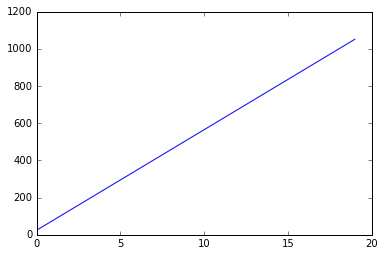

In [20]:
# This is what linear looks like....
%pylab inline
plot([54 * x + 25 for x in range(20)])

In [17]:
# Return the subset of words that is in word_counts.
def known(words):
    return set(w for w in words if w in word_counts)  # there are more efficient ways of doing this...

known(['apple', 'zzzzasdfasdfz'])

{'apple'}

In [18]:
def correct(word):
    # NB: 'or' returns whichever is the first non-empty value
    candidates = known([word]) or \
                 known(edits(word)) or \
                 [word]
    return max(candidates, key=word_counts.get)

In [19]:
print(correct('apple'))   # apple is in word_counts: known([word])
print(correct('accross')) # accross is not in word_counts, but across is: known(edits(word))
print(correct('zebraa'))  # zebra is not in word_counts: [word]

apple
across
zebraa


# How to use spelling correction?

- Make suggestions ("Did you mean?")
- Add corrected terms to query
  - only if query term is not in dictionary
  - only if number of matches < N